In [ ]:
import os
import numpy as np
import shutil
import random
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
#parameter konstan
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = "../content/drive/MyDrive/Data/rice dataset"

bacterial_dir = os.path.join(base_dir, 'Bacterial leaf blight')
brown_dir = os.path.join(base_dir, 'Brown spot')
smut_dir = os.path.join(base_dir, 'Leaf smut')

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 120 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

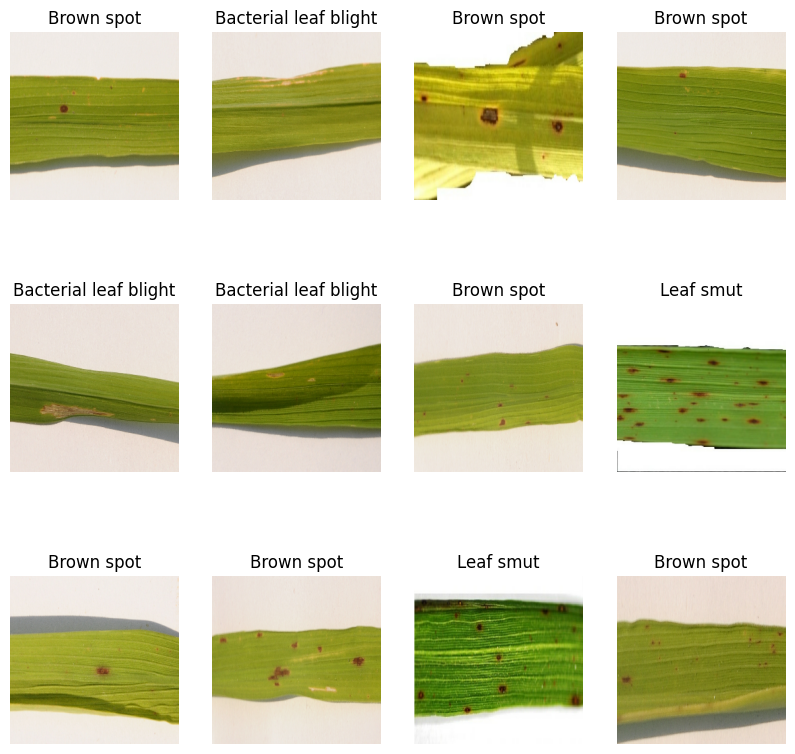

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
directories = [bacterial_dir, brown_dir, smut_dir]
file_lists = [[os.path.join(d, f) for f in os.listdir(d)] for d in directories]

for files in file_lists:
    print(len(files))

40
40
40


In [ ]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_files = []
val_files = []
test_files = []

for files in file_lists:
    random.shuffle(files)  # Shuffle the files in each directory
    num_train = int(len(files) * train_ratio)
    num_val = int(len(files) * val_ratio)

    train_files.append(files[:num_train])
    val_files.append(files[num_train:num_train+num_val])
    test_files.append(files[num_train+num_val:])

print(f'Total training files: {sum([len(files) for files in train_files])}')
print(f'Total validation files: {sum([len(files) for files in val_files])}')
print(f'Total test files: {sum([len(files) for files in test_files])}')

Total training files: 84
Total validation files: 18
Total test files: 18


In [ ]:
train_dir = '/content/train'  # path folder baru untuk data train
val_dir = '/content/validation'  # path folder baru untuk data validation
test_dir = '/content/test'  # path folder baru untuk data test

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for files in train_files:
    label = os.path.basename(os.path.dirname(files[0]))
    label_dir = os.path.join(train_dir, label)
    os.makedirs(label_dir, exist_ok=True)
    for file in files:
        shutil.copy2(file, label_dir)

for files in val_files:
    label = os.path.basename(os.path.dirname(files[0]))
    label_dir = os.path.join(val_dir, label)
    os.makedirs(label_dir, exist_ok=True)
    for file in files:
        shutil.copy2(file, label_dir)

for files in test_files:
    label = os.path.basename(os.path.dirname(files[0]))
    label_dir = os.path.join(test_dir, label)
    os.makedirs(label_dir, exist_ok=True)
    for file in files:
        shutil.copy2(file, label_dir)

#Data Augmentasi

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=20,
    horizontal_flip=True
    )

val_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset from directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

Found 84 images belonging to 3 classes.
Found 18 images belonging to 3 classes.
Found 18 images belonging to 3 classes.


#Fungsi Awal

In [ ]:
##..........................
# direktori saved model
##..........................
saved_model_dir = "/content/saved_model"
saved_model_his = "/content/saved_model_history"

os.mkdir(saved_model_dir)
os.mkdir(saved_model_his)


In [ ]:
##..........................
# simpan model
##..........................

import pickle

# simpan saved model
def saved_model(model, modelname):
  export_path = os.path.join(saved_model_dir, modelname)
  if os.path.isdir(export_path):
    print('\nAlready saved a model, replace to new model\n')
    shutil.rmtree(export_path, ignore_errors=True)

  model.save(export_path)
  print("Export path: ", export_path)
  print(os.listdir(export_path))

# simpan model history
def saved_model_history(history, modelname):
  with open(os.path.join(saved_model_his, modelname), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
from google.colab import files
os.mkdir("/content/modelh5")
saved_model_h5 = "/content/modelh5"

def savedh5(model, model_name):
    model_dir = os.path.join(saved_model_h5, model_name)
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, model_name + ".h5")
    model.save(model_path)
    files.download(model_path)
    print("Model berhasil disimpan di:", model_path)

In [ ]:
##..........................
#learning curve
##..........................

def plot_learning_curves(history):
  acc      = history.history[     'accuracy' ]
  val_acc  = history.history[ 'val_accuracy' ]
  loss     = history.history[    'loss' ]
  val_loss = history.history['val_loss' ]

  epochs   = range(len(acc))


  plt.plot  ( epochs,     acc, label='Training')
  plt.plot  ( epochs, val_acc, label='Validation')
  plt.title ('Training and validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot  ( epochs,     loss, label='Training')
  plt.plot  ( epochs, val_loss, label='Validation')
  plt.legend()
  plt.title ('Training and validation loss')

In [ ]:
##..........................
#Confudion matrix
##..........................

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def cf_matrix(model):
    # Memprediksi label menggunakan model
    y_pred = model.predict(test_generator)
    y_pred = np.argmax(y_pred, axis=1)

    # Mendapatkan label sebenarnya dari test_generator
    y_true = test_generator.classes

    # Menghitung matriks kebingungan
    cm = confusion_matrix(y_true, y_pred)

    # Mendapatkan nama kelas dari test_generator
    class_names = list(test_generator.class_indices.keys())

    # Visualisasi matriks kebingungan dalam bentuk heatmap
    plt.figure(figsize=(8, 6), dpi=100)
    plt.subplot(2, 1, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Membuat laporan klasifikasi
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(report)


#Model CNN

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [ ]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax'),
])

model1.build(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [ ]:
model1.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 30, 30, 64)     

In [ ]:
model1.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
# Train the model
history1 = model1.fit(train_generator,
                    batch_size=32,
                    validation_data = val_generator,
                    verbose = 1,
                    validation_steps=1,
                    epochs=50
                    )

Epoch 1/50
3/3 [==============================] - ETA: 0s - loss: 1.1379 - accuracy: 0.2738

3/3 [==============================] - 8s 1s/step - loss: 1.1379 - accuracy: 0.2738 - val_loss: 1.0947 - val_accuracy: 0.3333
Epoch 2/50
3/3 [==============================] - 4s 1s/step - loss: 1.1045 - accuracy: 0.3095 - val_loss: 1.0968 - val_accuracy: 0.3333
Epoch 3/50
3/3 [==============================] - 5s 2s/step - loss: 1.0980 - accuracy: 0.2976 - val_loss: 1.0968 - val_accuracy: 0.3333
Epoch 4/50
3/3 [==============================] - 4s 1s/step - loss: 1.0967 - accuracy: 0.3333 - val_loss: 1.0960 - val_accuracy: 0.3333
Epoch 5/50
3/3 [==============================] - 4s 1s/step - loss: 1.0956 - accuracy: 0.3333 - val_loss: 1.0955 - val_accuracy: 0.3333
Epoch 6/50
3/3 [==============================] - 5s 2s/step - loss: 1.0924 - accuracy: 0.3571 - val_loss: 1.0934 - val_accuracy: 0.3889
Epoch 7/50
3/3 [==============================] - 6s 2s/step - loss: 1.0900 - accuracy: 0.4048 - val_loss: 1.0906 - val_accuracy: 0.3889
Epoch 8/50
3/3 [==============================] - 4s

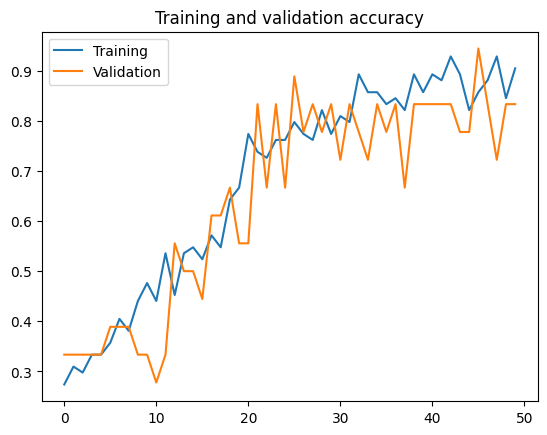

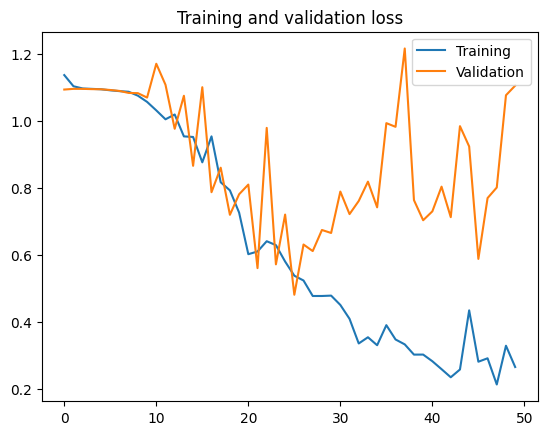

In [ ]:
# learning curve
plot_learning_curves(history1)

1/1 [==============================] - 1s 1s/step


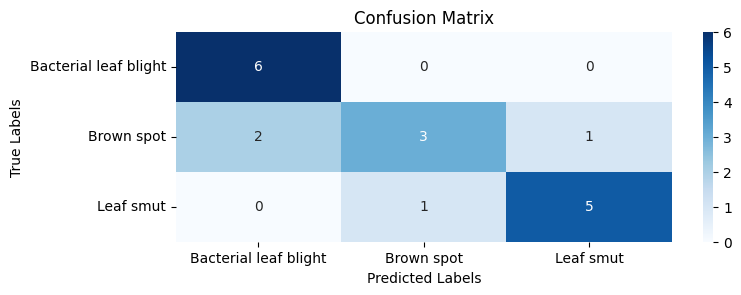

                       precision    recall  f1-score   support

Bacterial leaf blight       0.75      1.00      0.86         6
           Brown spot       0.75      0.50      0.60         6
            Leaf smut       0.83      0.83      0.83         6

             accuracy                           0.78        18
            macro avg       0.78      0.78      0.76        18
         weighted avg       0.78      0.78      0.76        18



In [ ]:
# cf matrix
cf_matrix(model1)

In [ ]:
savedh5(model1, "model1_rice")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model berhasil disimpan di: /content/modelh5/model1_rice/model1_rice.h5


In [ ]:
saved_model(model1, "model1_rice")
saved_model_history(model1, "history1")

Export path:  /content/saved_model/model1_rice
['variables', 'assets', 'keras_metadata.pb', 'fingerprint.pb', 'saved_model.pb']


#Model NasNet

In [ ]:
base_model=tf.keras.applications.NASNetMobile(include_top=False, weights="imagenet",input_shape=(256,256,3))

19993432/19993432 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

model2 = tf.keras.Sequential([
            base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(3, activation='softmax')
])

model2.build(input_shape=(32,256,256,3))
model2.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 8, 8, 1056)        4269716   
                                                                 
 conv2d_72 (Conv2D)          (None, 8, 8, 32)          304160    
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 4, 4, 32)         0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 4, 4, 32)          0         
                                                                 
 flatten_12 (Flatten)        (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 3)                 1539      
                                                     

In [ ]:
opt = Adam(learning_rate=0.001)

model2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
# Train the model
history2 = model2.fit(train_generator,
                    batch_size=20,
                    validation_data = val_generator,
                    verbose = 1,
                    validation_steps=1,
                    epochs=50
                    )

Epoch 1/50
3/3 [==============================] - 23s 4s/step - loss: 1.6732 - accuracy: 0.4405 - val_loss: 0.7954 - val_accuracy: 0.5556
Epoch 2/50
3/3 [==============================] - 4s 1s/step - loss: 0.9635 - accuracy: 0.6310 - val_loss: 0.5589 - val_accuracy: 0.7222
Epoch 3/50
3/3 [==============================] - 5s 2s/step - loss: 0.6656 - accuracy: 0.7976 - val_loss: 0.6374 - val_accuracy: 0.6667
Epoch 4/50
3/3 [==============================] - 4s 1s/step - loss: 0.6189 - accuracy: 0.7857 - val_loss: 0.5405 - val_accuracy: 0.7778
Epoch 5/50
3/3 [==============================] - 4s 2s/step - loss: 0.4764 - accuracy: 0.8214 - val_loss: 0.4202 - val_accuracy: 0.8333
Epoch 6/50
3/3 [==============================] - 5s 2s/step - loss: 0.3270 - accuracy: 0.8333 - val_loss: 0.3494 - val_accuracy: 0.9444
Epoch 7/50
3/3 [==============================] - 4s 1s/step - loss: 0.3116 - accuracy: 0.8690 - val_loss: 0.4844 - val_accuracy: 0.7778
Epoch 8/50
3/3 [========================

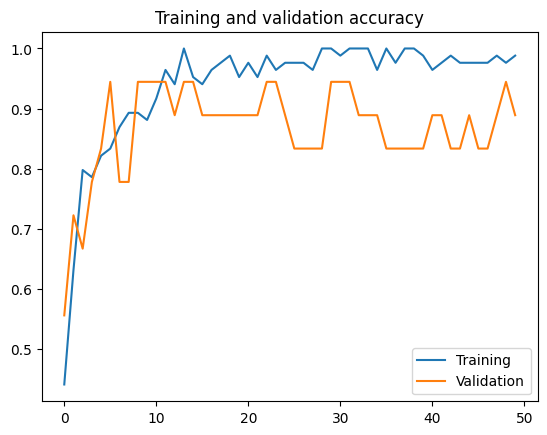

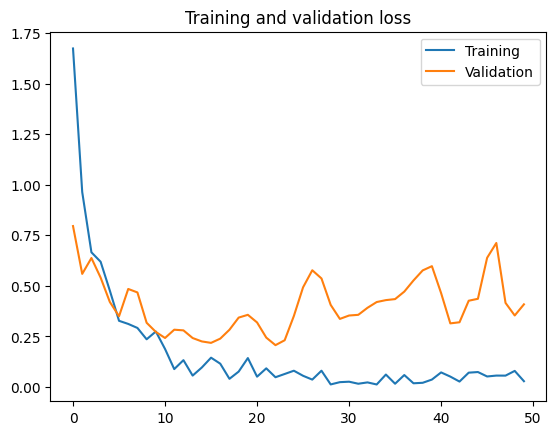

In [ ]:
plot_learning_curves(history2)

1/1 [==============================] - 5s 5s/step


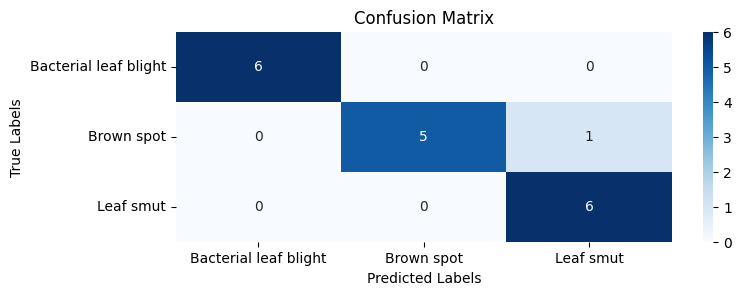

                       precision    recall  f1-score   support

Bacterial leaf blight       1.00      1.00      1.00         6
           Brown spot       1.00      0.83      0.91         6
            Leaf smut       0.86      1.00      0.92         6

             accuracy                           0.94        18
            macro avg       0.95      0.94      0.94        18
         weighted avg       0.95      0.94      0.94        18



In [ ]:
#cf matrix
cf_matrix(model2)

In [ ]:
savedh5(model2, "model2_rice")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model berhasil disimpan di: /content/modelh5/model2_rice/model2_rice.h5


In [ ]:
saved_model(model2, "model2_rice")
saved_model_history(model2, "history2")

Export path:  /content/saved_model/model2_rice
['variables', 'assets', 'keras_metadata.pb', 'fingerprint.pb', 'saved_model.pb']


#Model 3 | VG16

In [ ]:
categories = list(train_generator.class_indices.keys())
print(val_generator.class_indices)

{'Bacterial leaf blight': 0, 'Brown spot': 1, 'Leaf smut': 2}


In [ ]:
base_model3 = tf.keras.applications.VGG16(weights = 'imagenet',
                                                include_top = False,
                                                input_shape = (256, 256, 3)
                                                )

In [ ]:
base_model3.trainable = False

model3 = tf.keras.Sequential([
            base_model3,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(3, activation='softmax')
])

model3.build(input_shape=(32,256,256,3))
model3.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 conv2d_75 (Conv2D)          (None, 8, 8, 32)          147488    
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 4, 4, 32)         0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 4, 4, 32)          0         
                                                                 
 flatten_15 (Flatten)        (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 3)                 1539      
                                                     

In [ ]:
model3.compile(optimizer = 'adam',
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics = ['accuracy'])

In [ ]:
# Train the model
history3 = model3.fit(train_generator,
                    batch_size=20,
                    validation_data = val_generator,
                    verbose = 1,
                    validation_steps=1,
                    epochs=50
                    )

Epoch 1/50
3/3 [==============================] - 10s 4s/step - loss: 1.4791 - accuracy: 0.3214 - val_loss: 1.0210 - val_accuracy: 0.3333
Epoch 2/50
3/3 [==============================] - 4s 1s/step - loss: 1.0593 - accuracy: 0.4286 - val_loss: 0.9859 - val_accuracy: 0.3889
Epoch 3/50
3/3 [==============================] - 5s 2s/step - loss: 0.9846 - accuracy: 0.4881 - val_loss: 0.8925 - val_accuracy: 0.7222
Epoch 4/50
3/3 [==============================] - 4s 1s/step - loss: 0.9005 - accuracy: 0.5714 - val_loss: 0.8157 - val_accuracy: 0.6667
Epoch 5/50
3/3 [==============================] - 6s 2s/step - loss: 0.8782 - accuracy: 0.5952 - val_loss: 0.7164 - val_accuracy: 0.7778
Epoch 6/50
3/3 [==============================] - 4s 1s/step - loss: 0.7158 - accuracy: 0.6786 - val_loss: 0.6839 - val_accuracy: 0.7222
Epoch 7/50
3/3 [==============================] - 4s 2s/step - loss: 0.7305 - accuracy: 0.7976 - val_loss: 0.5796 - val_accuracy: 0.7222
Epoch 8/50
3/3 [========================

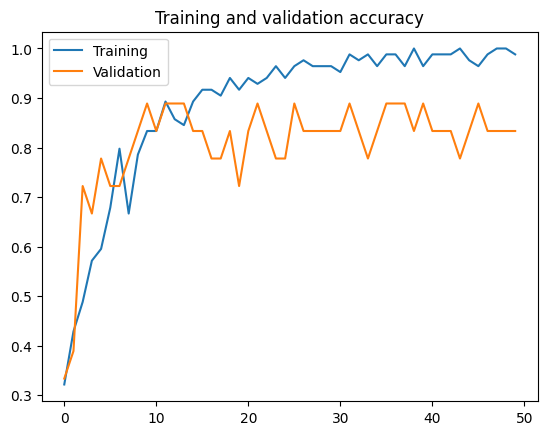

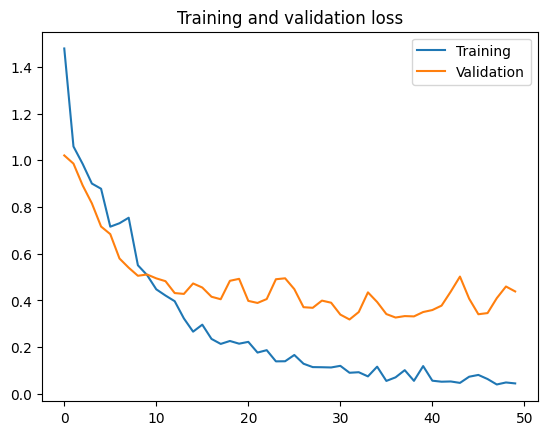

In [ ]:
plot_learning_curves(history3)

1/1 [==============================] - 1s 835ms/step


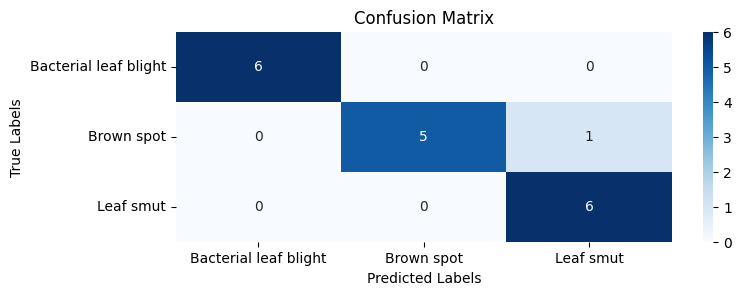

                       precision    recall  f1-score   support

Bacterial leaf blight       1.00      1.00      1.00         6
           Brown spot       1.00      0.83      0.91         6
            Leaf smut       0.86      1.00      0.92         6

             accuracy                           0.94        18
            macro avg       0.95      0.94      0.94        18
         weighted avg       0.95      0.94      0.94        18



In [ ]:
cf_matrix(model3)

#Prediksi

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 32ms/step


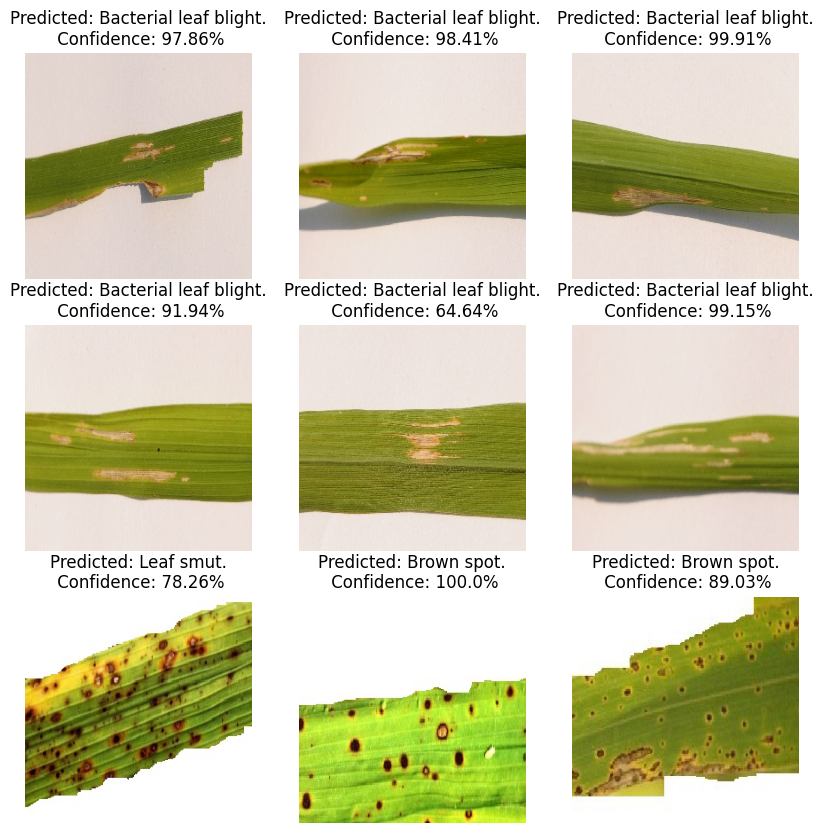

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])

        predicted_class, confidence = predict(model3, images[i])

        plt.title(f"Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")
    break